In [1]:
import os

from cities.deployment.tracts_minneapolis.predict import TractsModelPredictor

from cities.utils.plot_ts import (plot_coefs, summarize_time_series,
                                  plot_model_summary, plot_selected_series)

from chirho.indexed.ops import IndexSet, gather, indices_of

from chirho.counterfactual.handlers import MultiWorldCounterfactual
from chirho.interventional.handlers import do

from cities.utils.data_loader import db_connection
import time
import torch
import pyro


import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

smoke_test = "CI" in os.environ

n_steps = 10 if smoke_test else 2000
num_samples = 10 if smoke_test else 1000

In [2]:
#print(predictor.factual_samples['destandardized_housing_units_cumulative'].shape)

factual_intervention = {"radius_blue": 106.7, "limit_blue": 0, "radius_yellow_line": 402.3, "radius_yellow_stop": 804.7, "limit_yellow": 0.5, "reform_year": 2015}
extreme_intervention = {"radius_blue": 1400, "limit_blue": 0, "radius_yellow_line": 2640, "radius_yellow_stop": 4000, "limit_yellow": 0.3, "reform_year": 2012}


start = time.time()
with db_connection() as conn:
    predictor = TractsModelPredictor(conn)
    # factual_intervention = predictor._tracts_intervention(conn, **factual_intervention)
    # extreme_intervention = predictor._tracts_intervention(conn, **extreme_intervention)

    end_loading = time.time()
#    prediction_factual = predictor.predict_cumulative(conn, factual_intervention)
    prediction_extreme = predictor.predict_cumulative(conn, extreme_intervention)

end = time.time()   

print("Time to load:", end_loading - start)
print("Time to make a prediction: ", end - end_loading)
      

Time to load: 14.028129816055298
Time to make a prediction:  8.755432844161987


In [10]:
print(prediction_extreme.keys())

def print_structure(nested_list, level=0):
    if isinstance(nested_list, list):
        print("  " * level + f"List of length {len(nested_list)}:")
        for item in nested_list:
            if isinstance(item, list):
                print_structure(item, level + 1)
    else:
        print("  " * level + f"Item: {nested_list}")

print("observed")
print_structure(prediction_extreme['housing_units_observed'])
print("factual means")
print_structure(prediction_extreme['housing_units_factual_means'])
print("factual samples")
print_structure(prediction_extreme['housing_units_factual_samples'])

dict_keys(['census_tracts', 'years', 'housing_units_observed', 'housing_units_factual_means', 'housing_units_factual_low', 'housing_units_factual_high', 'housing_units_factual_samples', 'housing_units_intervened_means', 'housing_units_intervened_low', 'housing_units_intervened_high', 'housing_units_intervened_samples'])
observed
List of length 10:
  List of length 113:
  List of length 113:
  List of length 113:
  List of length 113:
  List of length 113:
  List of length 113:
  List of length 113:
  List of length 113:
  List of length 113:
  List of length 113:
factual means
List of length 10:
  List of length 113:
  List of length 113:
  List of length 113:
  List of length 113:
  List of length 113:
  List of length 113:
  List of length 113:
  List of length 113:
  List of length 113:
  List of length 113:
factual samples
List of length 10:
  List of length 113:
    List of length 200:
    List of length 200:
    List of length 200:
    List of length 200:
    List of length 200:


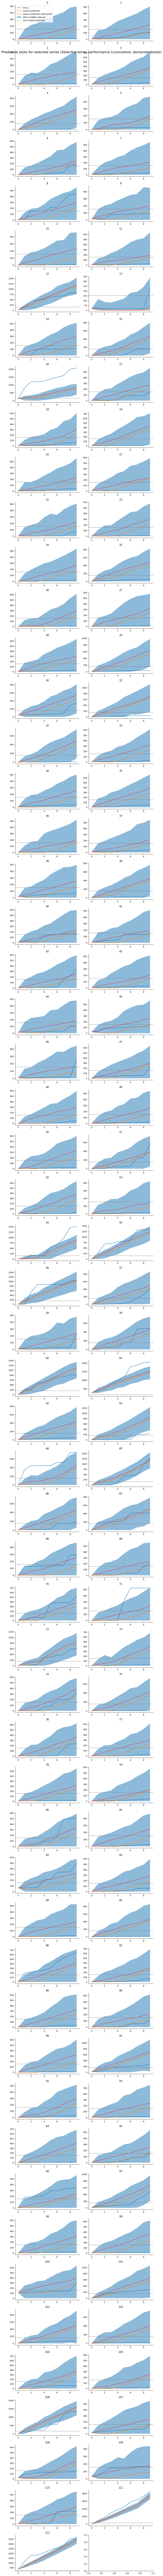

In [3]:

plot_selected_series(
    predictor.factual_summary,
    y_true = predictor.observed_housing_cumulative,
    intervened_summary=predictor.intervened_summary,
    selected_series=range(113),
    title="Selected series performance (cumulative, destandardized)",
    plot_null=True,
    #path = "ts_selected_series_destandardized_cumulative.png",
    add_metrics = False,
)
